### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [229]:
data = np.load('/home/rothj1/Desktop/AstroStats/repos/astr_8070_s24/coursework/homeworks/hw_data/hw8_data_1.npy')
data

array([(19.46392, 18.89363, 18.85225, 18.8241 , 18.53599, 'QSO', 2.312959  , 1.925222e-04),
       (18.33262, 16.29118, 15.3018 , 14.81997, 14.45467, 'GALAXY', 0.05187586, 1.396275e-05),
       (18.85941, 17.01412, 15.97252, 15.51533, 15.11948, 'GALAXY', 0.09769295, 1.805014e-05),
       ...,
       (18.76492, 18.12947, 18.04838, 17.94089, 17.677  , 'QSO', 2.267401  , 1.777254e-04),
       (19.36827, 19.06754, 18.9035 , 18.84508, 18.82694, 'QSO', 1.407278  , 8.702147e-04),
       (19.37275, 18.82985, 18.69858, 18.53639, 18.43456, 'QSO', 0.6865192 , 1.417279e-04)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [230]:
# create arrays
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
redshift = data['redshift']
specClass = data['specClass']

In [231]:
# get number of galaxies and quasars 
quasar_idxs = np.where(specClass=='QSO')
gal_idxs = np.where(specClass=='GALAXY')

quasars = specClass[quasar_idxs]
galaxies = specClass[gal_idxs]

print(len(quasars),'quasars')
print(len(galaxies),'galaxies')

# check if any other types that were missed
if len(specClass) == len(quasars)+len(galaxies):
    print('No other types')

7192 quasars
42808 galaxies
No other types


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


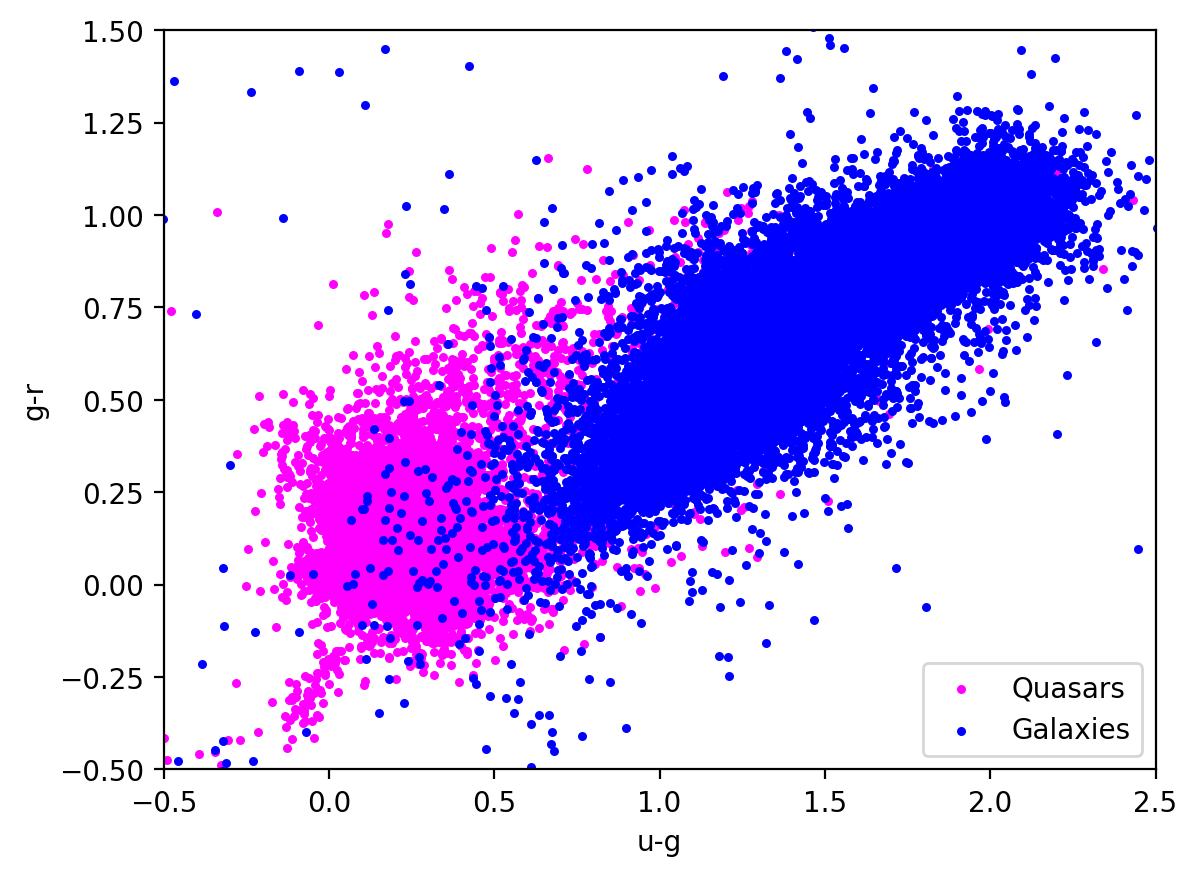

In [232]:
plt.scatter(ug[quasar_idxs],gr[quasar_idxs],color='magenta',s=5,label='Quasars')
plt.scatter(ug[gal_idxs],gr[gal_idxs],color='blue',s=5,label='Galaxies')

plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.xlabel('u-g')
plt.ylabel('g-r')
plt.legend()
plt.show()

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [233]:
# stack colors and redshift into X
X = np.vstack([ug,gr,ri,iz,redshift])
print(X.shape)

# target labels
target_labels = np.empty(shape=redshift.shape)
target_labels[gal_idxs] = 0
target_labels[quasar_idxs] = 1
print(target_labels.shape)

(5, 50000)
(50000,)


In [234]:
# split 20 percent for testing 
from sklearn.model_selection import train_test_split

X_train, X_test, targ_train, targ_test = train_test_split(X.T, target_labels,test_size=0.2,random_state=123) # need transpose of X to get size (50k,2) and match y with size 50k
print(X_train.shape)
print(X_test.shape)
print(targ_train.shape)
print(targ_test.shape)

(40000, 5)
(10000, 5)
(40000,)
(10000,)



4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
Best model: N_features = 5


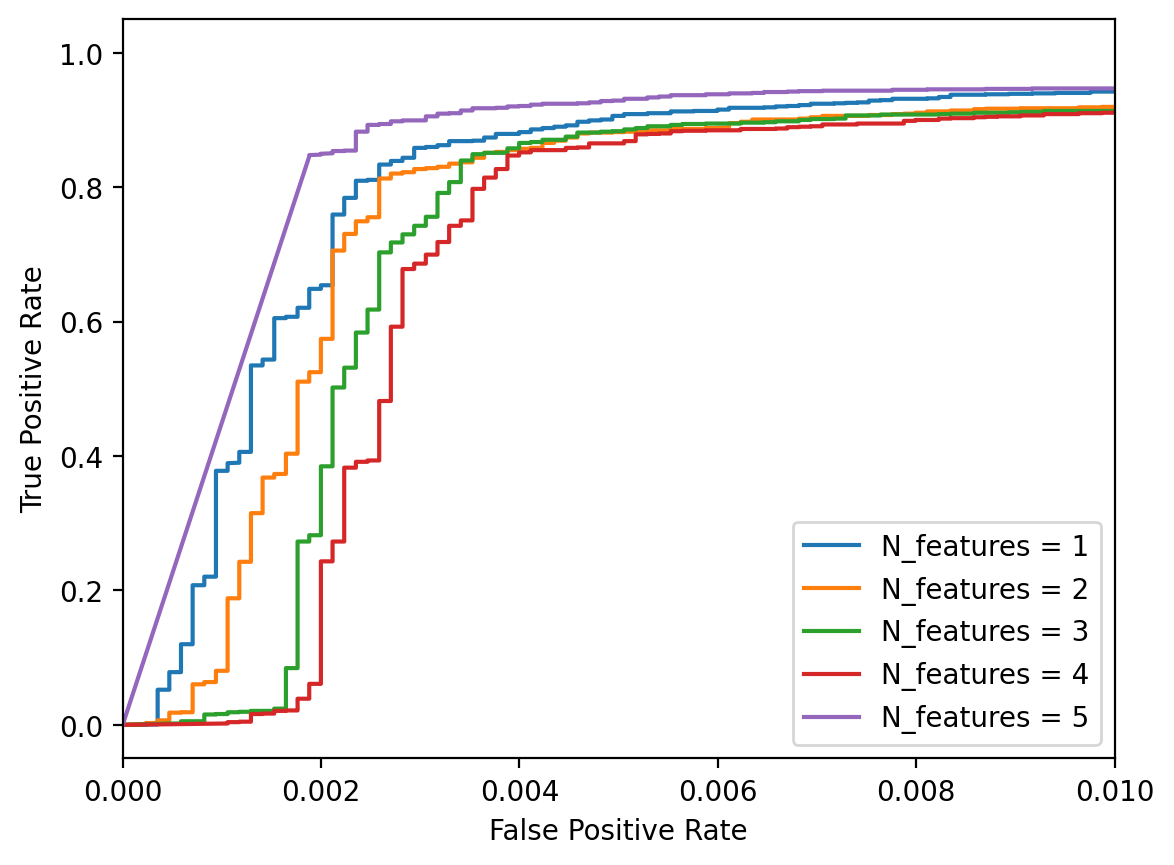

In [235]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

areas = []

# iterate over 5 data features
for i in range(5):

    # gaussian naive bayes fit & predict
    gnb = GaussianNB()
    gnb.fit(X_train[:,:(i+1)],targ_train) # first iter grabs first col, second grabs first two cols, etc
    print(gnb.classes_) # tells us that quasar class (1) is at index 1
    y_prob = gnb.predict_proba(X_test[:,:(i+1)])[:,1]

    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label='N_features = %i' % (i+1))

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: N_features = %i' % (best_idx+1))

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

This doesn't seem like there is one feature that strikingly makes the plot look best (if anything, would be the last feature, which is redshift). 

SRT: Good.

5. Repeat (4) for Quadratic Discriminant Analysis. 

Best model: N_features = 5


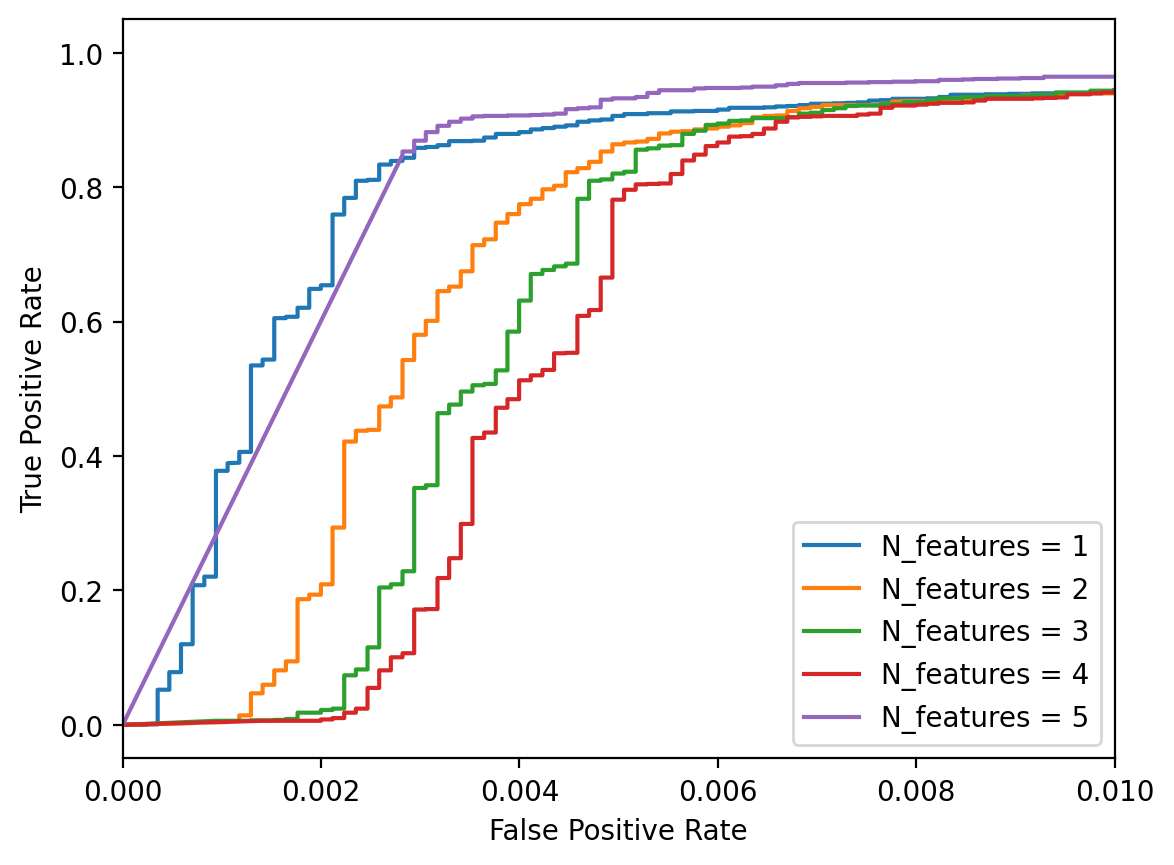

In [236]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

areas = []

# iterate over 5 data features
for i in range(5):

    # QDA fit & predict
    qda = QDA()
    qda.fit(X_train[:,:(i+1)],targ_train)
    y_prob = qda.predict_proba(X_test[:,:(i+1)])[:,1]

    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label='N_features = %i' % (i+1))

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: N_features = %i' % (best_idx+1))

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

In [237]:
X_train_colors = X_train[:,:4]
print(X_train_colors.shape)
X_train_colors[:,:10]
X_test_colors = X_test[:,:4]

(40000, 4)


Best model: N_components = 8


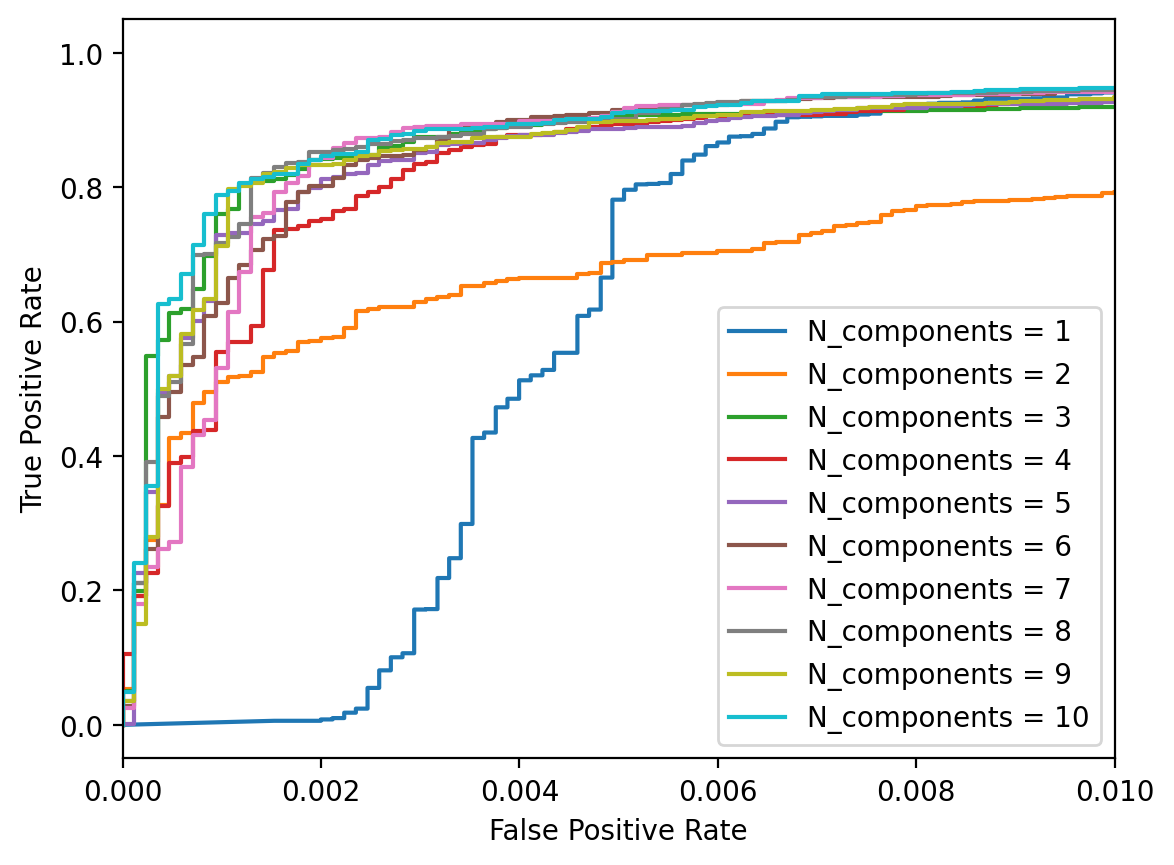

In [242]:
from astroML.classification import GMMBayes

areas = []
for i in range(10):
    
    #GMMBayes fit and predict
    gmmb = GMMBayes(n_components=(i+1))
    gmmb.fit(X_train_colors,targ_train)
    y_prob = gmmb.predict_proba(X_test_colors)[:,1]

    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label='N_components = %i' % (i+1))

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: N_components = %i' % (best_idx+1))

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

Best model: N_neighbors = 75


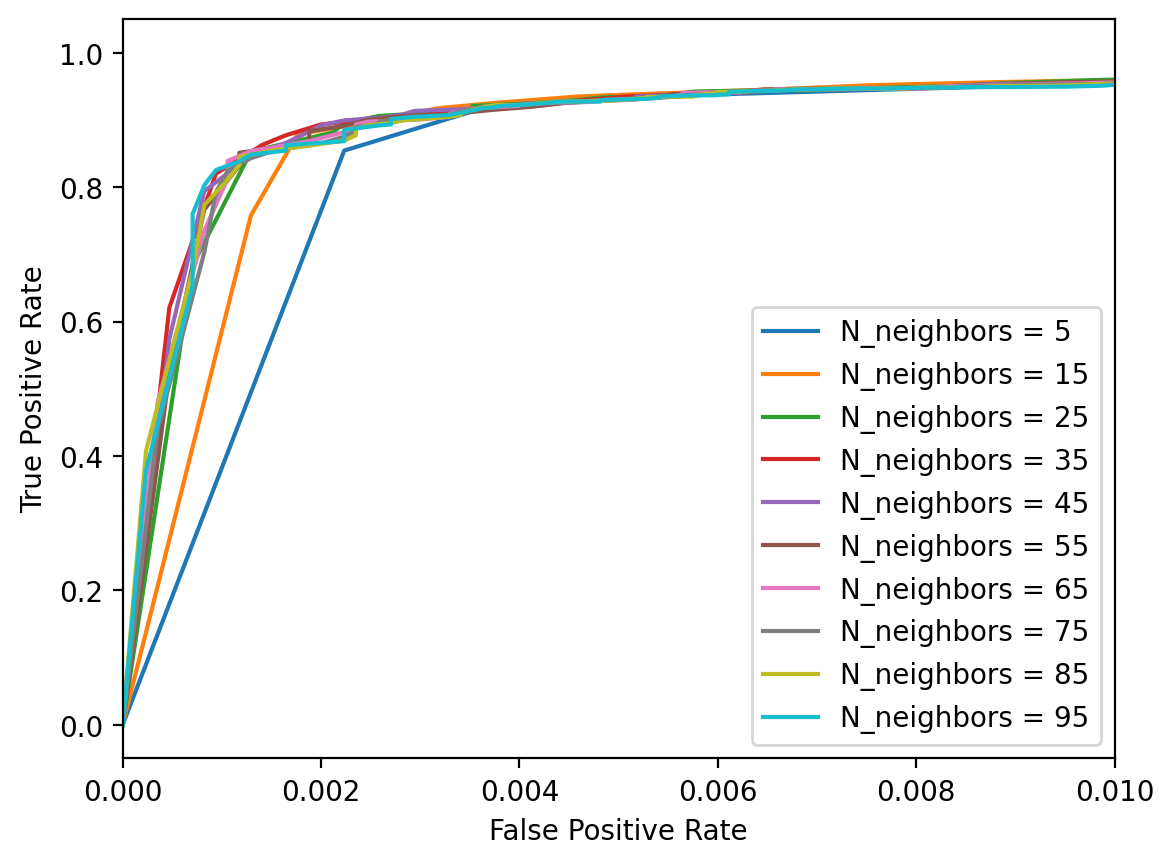

In [246]:
from sklearn.neighbors import KNeighborsClassifier

areas = []
nbrs = np.arange(5,100,10)

for num in nbrs:

    # KNN fit & predict
    knn = KNeighborsClassifier(n_neighbors=num)
    knn.fit(X_train_colors,targ_train)
    y_prob = knn.predict_proba(X_test_colors)[:,1]

    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label='N_neighbors = %i' % num)

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: N_neighbors = %i' % nbrs[best_idx])

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


Best model: Max depth = 8


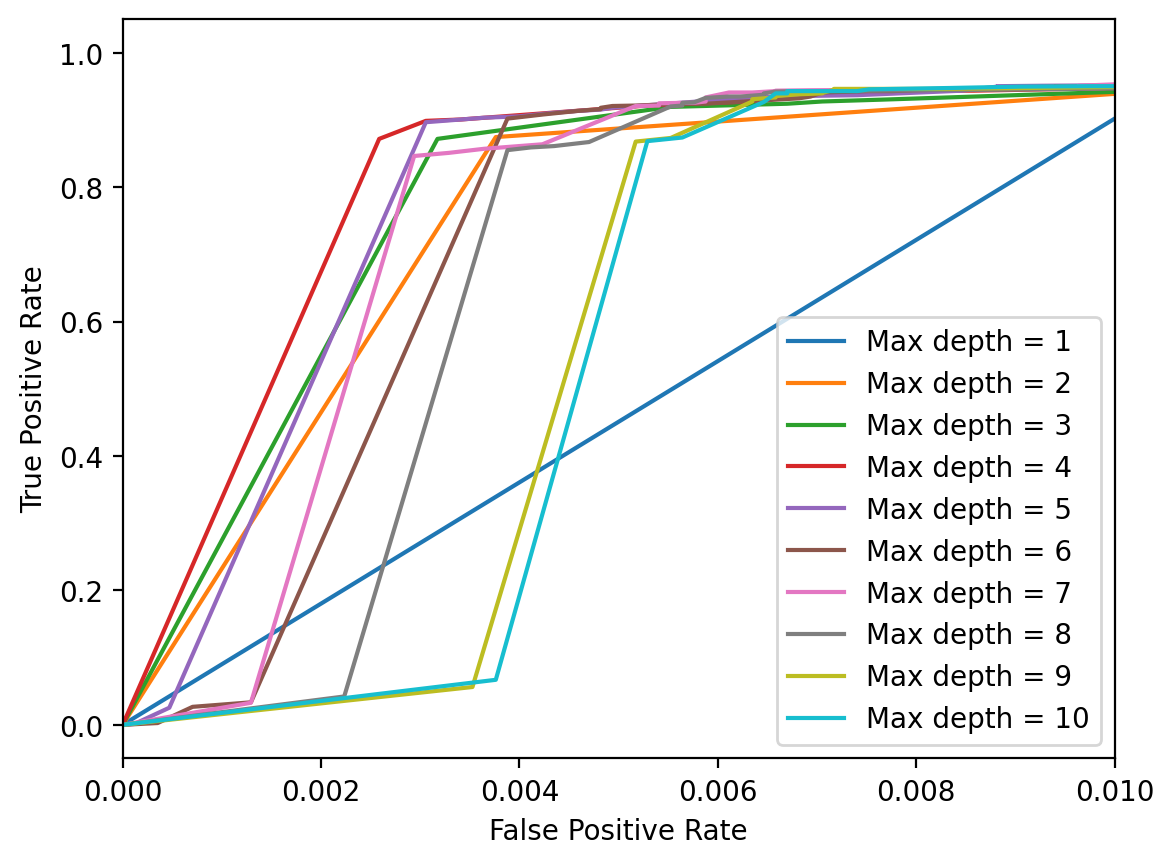

In [248]:
from sklearn.tree import DecisionTreeClassifier

depths = np.arange(1,11,1)

for dep in depths:

    # decision tree fit & predict
    dectree = DecisionTreeClassifier(max_depth=dep)
    dectree.fit(X_train_colors,targ_train)
    y_prob = dectree.predict_proba(X_test_colors)[:,1]

    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label='Max depth = %i' % dep)

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: Max depth = %i' % depths[best_idx])

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

Best model: =  KNN


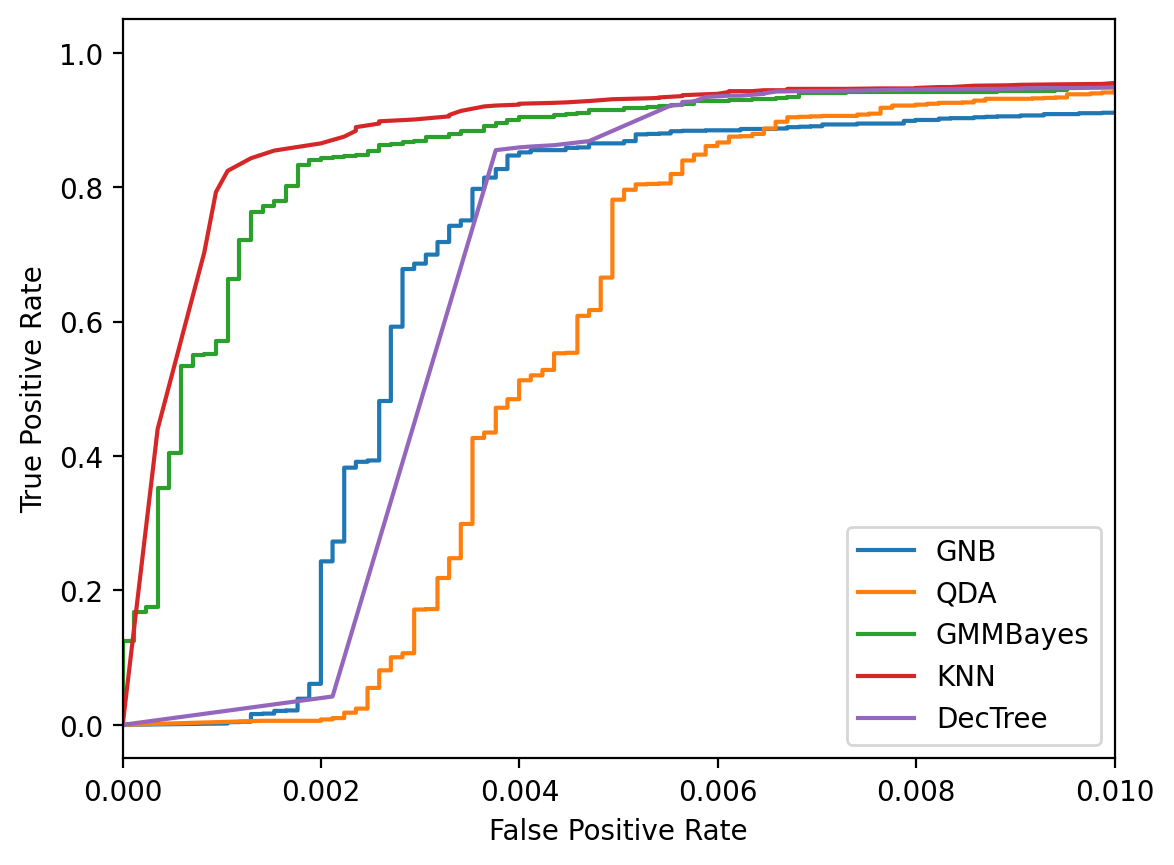

In [251]:

classifiers = [GaussianNB(),QDA(), GMMBayes(n_components=8),KNeighborsClassifier(n_neighbors=75),DecisionTreeClassifier(max_depth=8)]
clf_names = ['GNB','QDA','GMMBayes','KNN','DecTree']
areas = []

for i, classifier in enumerate(classifiers):
    
    clf = classifier
    clf.fit(X_train_colors,targ_train)
    y_prob = clf.predict_proba(X_test_colors)[:,1]
    
    # get ROC curve
    fpr, tpr, thresh = metrics.roc_curve(targ_test, y_prob)
    plt.plot(fpr,tpr,label=clf_names[i])

    # area under curve
    area = np.trapz(y=tpr,x=fpr)
    areas.append(area)

best_idx = areas.index(max(areas))
print('Best model: = ',clf_names[best_idx])

plt.xlim(0,0.01)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


KNN is the best classifier with n_neighbors = 75. This does seem to be a little finnicky though, as I noticed the answer changed to KNN from GMMBayes when I reran the split at the beginning which involves some randomness. This makes sense though, GMMBayes appears to be a close second to KNN here. In the individual classifiers, GMMBayes best number of components, KNN best number of neighbors, and Decision Tree best depth was changing a bit as well, which also makes some sense given how close the ROC curves were to each other.

SRT: Excellent investigation here, Jaelyn. There is indeed some fluctuation in the solution depending on the train/test split.

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [393]:
# get quasar and galaxy indices
quasar_idx2 = np.where(targ_train==1)
galaxy_idx2 = np.where(targ_train==0)

# check numbers
quasars2 = X_train[:,0][quasar_idx2] # doesnt matter which col of xtrain
galaxies2 = X_train[:,0][galaxy_idx2]
print(len(quasars2),'quasars')
print(len(galaxies2),'galaxies')
print(len(quasars2)+len(galaxies2))

5700 quasars
34300 galaxies
40000


In [404]:
# best performing classifier = KNN, run one more time
knn = KNeighborsClassifier(n_neighbors=75)
knn.fit(X_train,targ_train)
y_prob = knn.predict_proba(X_test)

In [405]:
knn_quasars_idx = np.where(y_prob[:,0]<y_prob[:,1]) # second col is prob of being quasar
knn_gxies_idx = np.where(y_prob[:,0]>y_prob[:,1]) # first col is prob of being galaxy

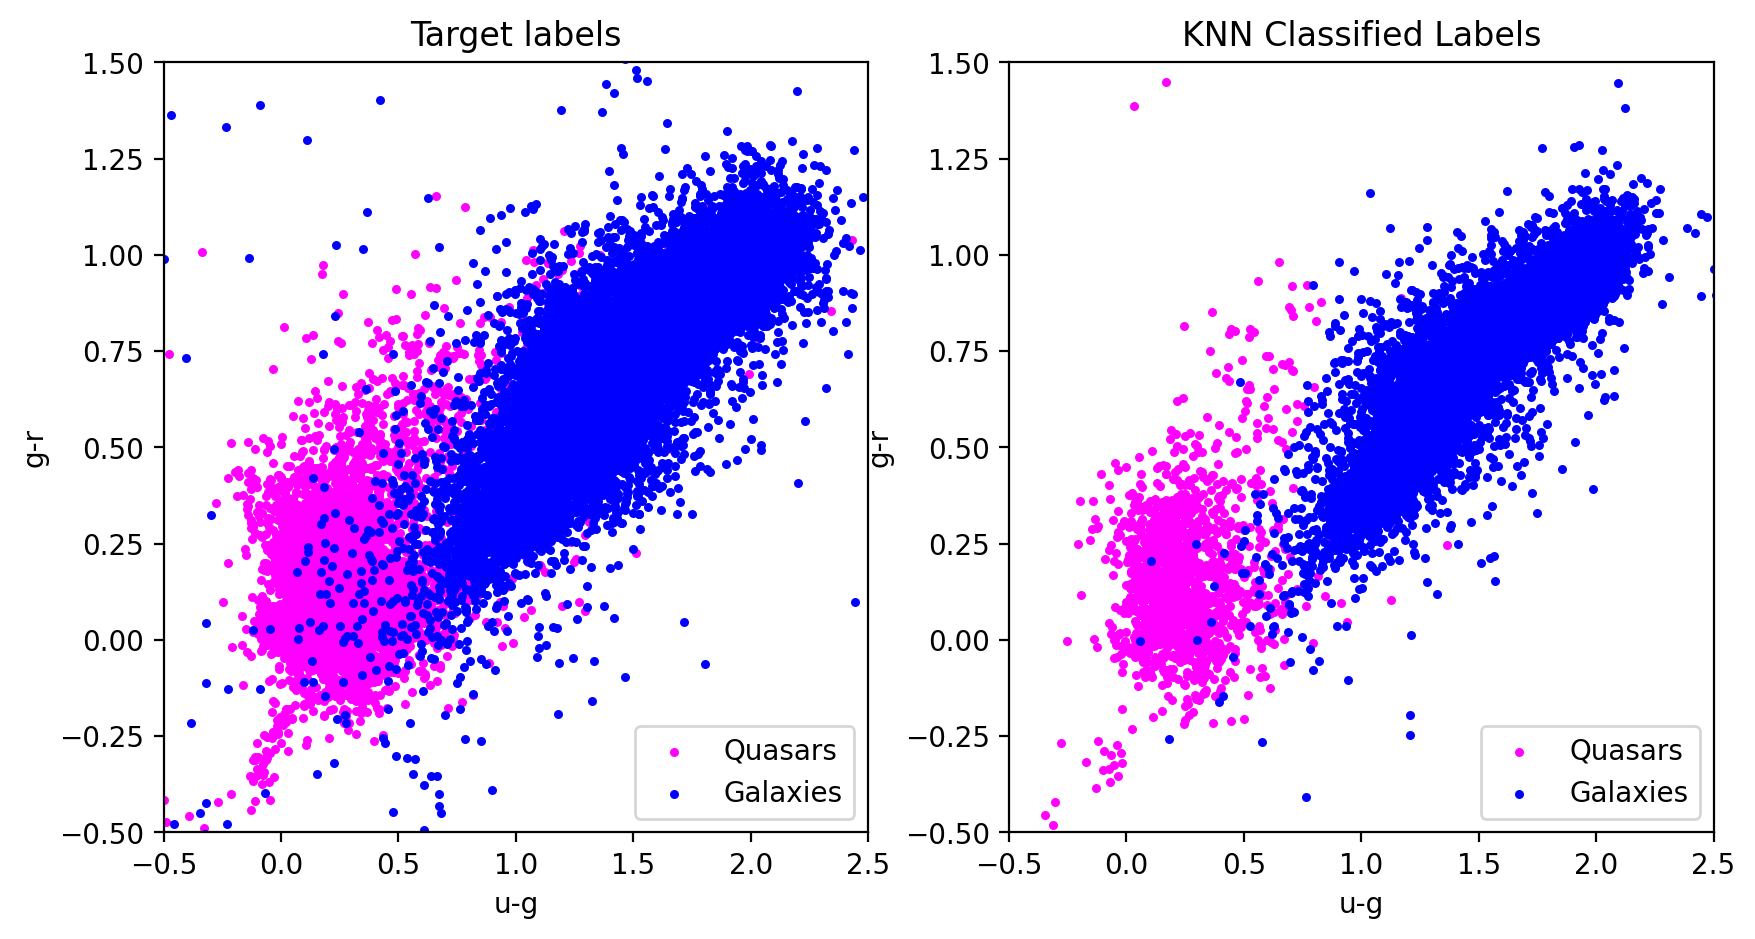

In [407]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

# original classification given from dataset
ug_train = X_train[:,0]
gr_train = X_train[:,1]
axes[0].scatter(x=ug_train[quasar_idx2],y=gr_train[quasar_idx2],s=5,color='magenta',label='Quasars')
axes[0].scatter(x=ug_train[galaxy_idx2],y=gr_train[galaxy_idx2],s=5,color='blue',label='Galaxies')
axes[0].set_title('Target labels')

# KNN classification using n_neighbors = 75
ug_test = X_test[:,0]
gr_test = X_test[:,1]
axes[1].scatter(x=ug_test[knn_quasars_idx],y=gr_test[knn_quasars_idx],s=5,color='magenta',label='Quasars')
axes[1].scatter(x=ug_test[knn_gxies_idx],y=gr_test[knn_gxies_idx],s=5,color='blue',label='Galaxies')
axes[1].set_title('KNN Classified Labels')

for i in range(2):
    axes[i].set_xlim(-0.5,2.5)
    axes[i].set_ylim(-0.5,1.5)
    axes[i].set_xlabel('u-g')
    axes[i].set_ylabel('g-r')
    axes[i].legend()

plt.show()

The biggest difference I see is in the number of points, since the KNN is plotted on the test data which is fewer than the training data. Other than that it looks like KNN does a pretty good job.

SRT: Well done!